In [ ]:
# Código do TCC - DSA222 - MBA em Data Science e Analytics - EaD 2º Sem /2022
# Por Marcos Roberto Rodrigues em março de 2024
# Objetivo é executar Rede Neural LSTM na Predição da Produtvidade de cana-se-açucar no Brasil

In [26]:
import math
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
from sklearn.preprocessing import MinMaxScaler 
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import tensorflow

In [27]:
# criando dataframe...
# na planilha tem 3 pastas: Área, Produtividade e Produção
# Na linha 6 tem a safra, na coluna A a localização, em estado sumarizando por região e total
# Vamos trabalhar com Produtividade que é o resultado da Produção dividido por Área

pd.options.mode.chained_assignment = None

file = '/Users/User/Documents/Marcos/CanaSerieHistZ.xls'
prodcana = pd.read_excel(file, sheet_name = 2)

df = pd.DataFrame(prodcana)
df.drop([0,1,2,3,40,41,42], inplace = True)
df.columns = df.iloc[0]
df.index = df['REGIÃO/UF']
df.drop(['REGIÃO/UF'], axis = 1, inplace = True)
df.drop(['REGIÃO/UF'], inplace = True)

df_invertido = df.transpose()


In [28]:

#https://ainfo.cnptia.embrapa.br/digital/bitstream/item/214997/1/Cap19-EvolucaoProducaoCanadeAcucar.pdf
#Extraido de um grafico
dados_numpy = np.array([61479, 61955, 64597, 63289, 67233, 66614, 66755, 68884, 69247, 68148, 67878, 69443, 71443, 73731, 73726])
ano_numpy = np.array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004])

TSAnterior = pd.Series(dados_numpy,index=[ano_numpy] )

TSAtual = df.loc['BRASIL']
TSAtual.index = TSAtual.index.str[0:4]
TSAtual = TSAtual.astype('int32')
TSTotal = pd.concat([TSAnterior, TSAtual])

linha_array = TSTotal.to_numpy().reshape(-1, 1)

dfSafra = pd.DataFrame(list(TSTotal.items()), columns=['Ano', 'Valor'])
dfSafra['Ano'] = dfSafra['Ano'].apply(lambda x: str(x).strip('(),'))
dfSafra = dfSafra.set_index('Ano')
#print(linha_array)
#print(dfSafra)
# Neste final temos linha_array com arrray com dados, ou dfSafra, com Ano como indice e dados, completo
# 

In [29]:

tamanho_dados_treinamento = int(len(linha_array) * 0.8)
tamanho_dados_teste = len(linha_array) - tamanho_dados_treinamento


In [30]:
#escalar os dados entre 0 e 1, para deixar mais fácil o processamento
#dados em escala pré definidas são mais fáceis de lidar. 

from sklearn.preprocessing import MinMaxScaler 

#Outra definição e a Normalização, que  é uma técnica que visa colocar os dados
#em uma escala comum, sem distorcer as diferenças nos intervalos de valores.

escalador = MinMaxScaler(feature_range=(0, 1))

# Nesta versão faze os escalar o todo linha_array.
safra = escalador.fit_transform(linha_array)


In [31]:
# Função para criar sequências de entrada e saída

def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)
    

In [32]:
# Criando sequências de entrada e saída, vai 
# Esta é outra alternativa de criar as array de teste e treinamento (parece mais esperta)
seq_length = 7
x, y = create_sequences(safra, seq_length)

# Dividindo os dados em conjuntos de treinamento e teste
split = int(0.8 * len(x))
x_train, x_test, y_train, y_test = x[:split], x[split:], y[:split], y[split:]

# Reshape dos dados para entrada na LSTM [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [33]:
#construindo o modelo
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
import tensorflow

modelo = Sequential()
modelo.add(LSTM(units=105, return_sequences=False))
modelo.add(Dense(7, 'relu'))
modelo.add(Dense(1, 'linear'))


In [34]:
#copilando o modelo

modelo.compile(optimizer="adam", loss="mean_squared_error") 

# A função de loss é a forma de medir o erro do modelo, que nesse caso
# é o classico erro médio quadrático da que é usado em regressão linear
# otimizador e medida de erro
# ETA é a abreviação de “Estimated Time of Arrival”. 
# No treinamento LSTM, o ETA é uma estimativa do tempo restante para o término do treinamento

modelo.fit(x_train, y_train, epochs=50, batch_size=32, verbose=2)


Epoch 1/50
1/1 - 2s - loss: 0.4706 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 0s - loss: 0.4139 - 7ms/epoch - 7ms/step
Epoch 3/50
1/1 - 0s - loss: 0.3628 - 8ms/epoch - 8ms/step
Epoch 4/50
1/1 - 0s - loss: 0.3343 - 7ms/epoch - 7ms/step
Epoch 5/50
1/1 - 0s - loss: 0.3177 - 8ms/epoch - 8ms/step
Epoch 6/50
1/1 - 0s - loss: 0.3004 - 7ms/epoch - 7ms/step
Epoch 7/50
1/1 - 0s - loss: 0.2827 - 7ms/epoch - 7ms/step
Epoch 8/50
1/1 - 0s - loss: 0.2647 - 7ms/epoch - 7ms/step
Epoch 9/50
1/1 - 0s - loss: 0.2465 - 7ms/epoch - 7ms/step
Epoch 10/50
1/1 - 0s - loss: 0.2281 - 7ms/epoch - 7ms/step
Epoch 11/50
1/1 - 0s - loss: 0.2090 - 8ms/epoch - 8ms/step
Epoch 12/50
1/1 - 0s - loss: 0.1886 - 7ms/epoch - 7ms/step
Epoch 13/50
1/1 - 0s - loss: 0.1668 - 7ms/epoch - 7ms/step
Epoch 14/50
1/1 - 0s - loss: 0.1451 - 8ms/epoch - 8ms/step
Epoch 15/50
1/1 - 0s - loss: 0.1239 - 14ms/epoch - 14ms/step
Epoch 16/50
1/1 - 0s - loss: 0.1040 - 7ms/epoch - 7ms/step
Epoch 17/50
1/1 - 0s - loss: 0.0861 - 6ms/epoch - 6ms/step
Epoch 

In [35]:
# Avaliando o modelo

loss = modelo.evaluate(x_test, y_test, verbose=0)

print(f'Loss: {loss}')

# Fazendo previsões
predictions = modelo.predict(x_test)

# Desnormalizando as previsões
predictions = escalador.inverse_transform(predictions)

for i in range(len(predictions)):
  #  print(f'{i+1}. Previsão: {predictions[i][0]:.2f}, Valor Real: {escalador.inverse_transform(y_test[i]):.2f}')
    print(f'{i+1}. Previsão: {predictions[i][0]:.2f}')
    #print(f'{i+1}. Valor Real: {escalador.inverse_transform(y_test[i][0]):.2f}')
   

Loss: 0.012164495885372162
1/1 [==============================] - 0s 366ms/step
1. Previsão: 73274.11
2. Previsão: 73677.76
3. Previsão: 74186.91
4. Previsão: 74335.97
5. Previsão: 74332.46
6. Previsão: 74054.99


In [36]:
#Pegando o Erro Médio Quadrático "Root-mean-square deviation (RMSE)""   ERRO ABSURDO DE GRANDE 161,58
y_test = escalador.inverse_transform(y_test)
rmse = np.sqrt(np.mean( predictions  - y_test) ** 2)
rmse

30.966145833333332

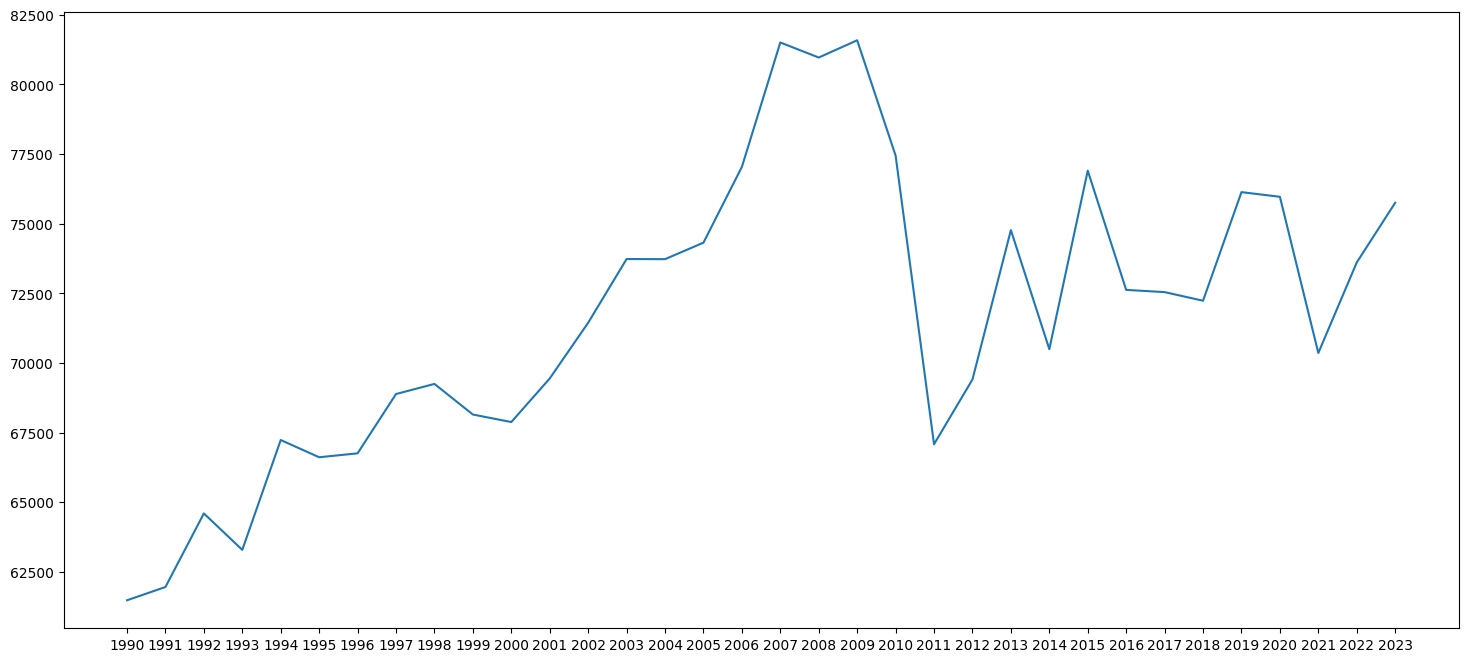

In [40]:
linha_array = linha_array.reshape(-1)

#Plotando gráfico inteiro
plt.figure(figsize =(18, 8))
plt.plot(dfSafra)

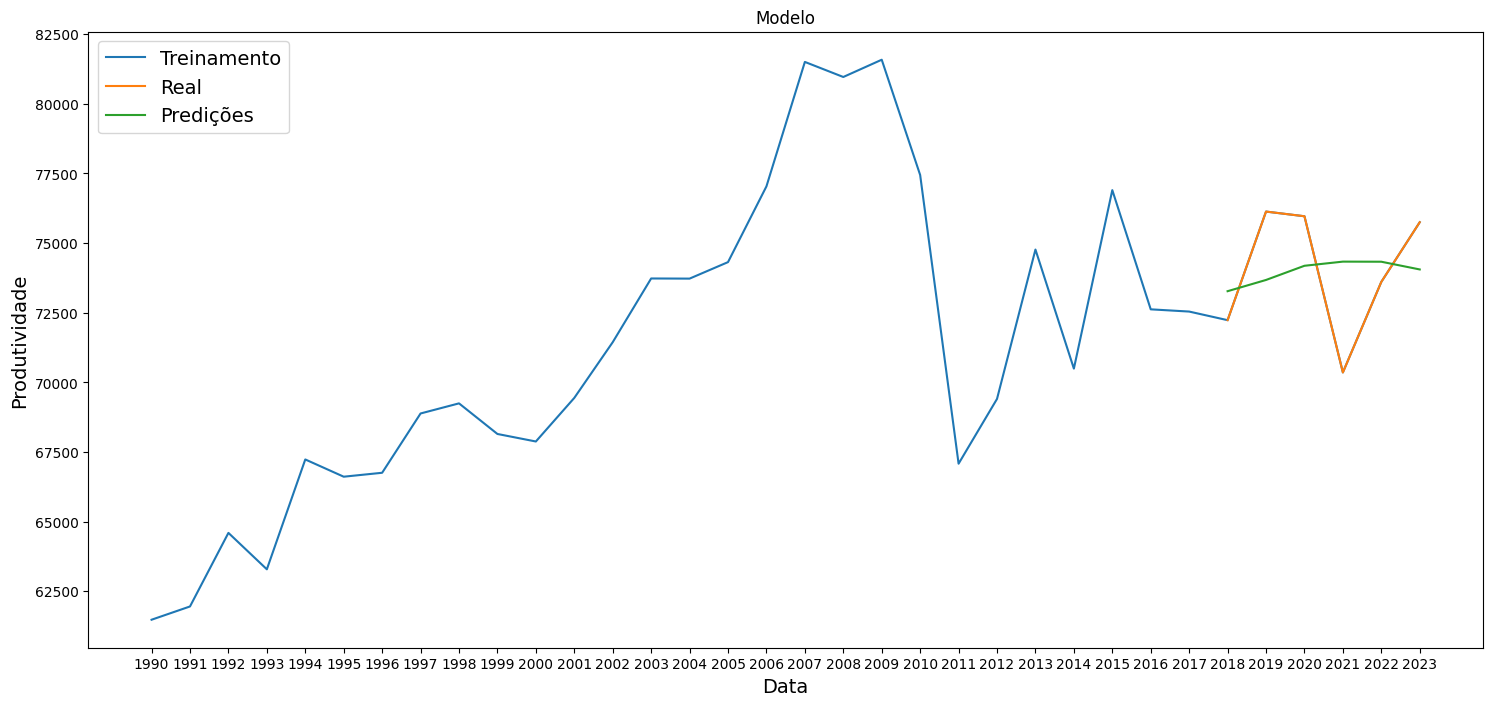

In [41]:
#criando o grafico do modelo

import pandas as pandas
treinamento = dfSafra

df_teste = pd.DataFrame({"Produtividade": linha_array[tamanho_dados_treinamento  + 1  :],
                        "Predicoes": predictions.reshape(len(predictions))})

df_teste = df_teste.set_index(dfSafra[tamanho_dados_treinamento + 1:].index)

plt.figure(figsize =(18, 8))
plt.title('Modelo')
plt.xlabel('Data', fontsize = 14)
plt.ylabel("Produtividade", fontsize = 14)
plt.plot(dfSafra)
#plt.plot(treinamento[:tamanho_dados_treinamento + 2])
plt.plot(df_teste[['Produtividade', 'Predicoes']])
plt.legend(['Treinamento', 'Real', 'Predições'], loc=2, prop={'size': 14})
plt.show()

# ATE AQUI ESTA RAZOAVELMENTE BEM, porém esse linha_traay não tem incidce não começa onde deveria
# num entendo pq 2017 nao aprece 

In [42]:
# Modelo compilado e dados preparados...
# agora podemos treinar o modelo

modelo.fit(x_train, y_train, batch_size=2, epochs=20, verbose = 2)


Epoch 1/20
11/11 - 0s - loss: 0.0574 - 71ms/epoch - 6ms/step
Epoch 2/20
11/11 - 0s - loss: 0.0448 - 39ms/epoch - 4ms/step
Epoch 3/20
11/11 - 0s - loss: 0.0482 - 43ms/epoch - 4ms/step
Epoch 4/20
11/11 - 0s - loss: 0.0410 - 51ms/epoch - 5ms/step
Epoch 5/20
11/11 - 0s - loss: 0.0413 - 44ms/epoch - 4ms/step
Epoch 6/20
11/11 - 0s - loss: 0.0426 - 37ms/epoch - 3ms/step
Epoch 7/20
11/11 - 0s - loss: 0.0390 - 33ms/epoch - 3ms/step
Epoch 8/20
11/11 - 0s - loss: 0.0425 - 33ms/epoch - 3ms/step
Epoch 9/20
11/11 - 0s - loss: 0.0385 - 42ms/epoch - 4ms/step
Epoch 10/20
11/11 - 0s - loss: 0.0415 - 36ms/epoch - 3ms/step
Epoch 11/20
11/11 - 0s - loss: 0.0414 - 32ms/epoch - 3ms/step
Epoch 12/20
11/11 - 0s - loss: 0.0428 - 40ms/epoch - 4ms/step
Epoch 13/20
11/11 - 0s - loss: 0.0408 - 39ms/epoch - 4ms/step
Epoch 14/20
11/11 - 0s - loss: 0.0377 - 37ms/epoch - 3ms/step
Epoch 15/20
11/11 - 0s - loss: 0.0377 - 36ms/epoch - 3ms/step
Epoch 16/20
11/11 - 0s - loss: 0.0383 - 37ms/epoch - 3ms/step
Epoch 17/20
11/11

In [43]:
df_teste.sort_index()

df_teste

,Produtividade,Predicoes
Ano,,
2018,72234,73274.109375
2019,76133,73677.757812
2020,75965,74186.914062
2021,70357,74335.968750
2022,73608,74332.460938
2023,75751,74054.992188


In [44]:

#calcular media de acertos e expectativa de lucro

df_teste['variacao_percentual_produtividade'] = df_teste['Produtividade'].pct_change()
df_teste['variacao_percentual_modelo'] = df_teste['Predicoes'].pct_change()

#df_teste = df_teste.dropna()

df_teste['var_produtidade_maior_menor_que_zero'] = np.where(df_teste['variacao_percentual_produtividade'] > 0, 
                                                      True, False)
df_teste['var_modelo_maior_menor_que_zero'] = np.where(df_teste['variacao_percentual_modelo'] > 0, 
                                                      True, False)

df_teste['acertou_o_lado'] = np.where(df_teste['var_produtidade_maior_menor_que_zero'] == df_teste['var_modelo_maior_menor_que_zero']
                                      , True, False)

df_teste['variacao_percentual_podutividade_abs'] = df_teste['variacao_percentual_produtividade'].abs()

df_teste


,Produtividade,Predicoes,variacao_percentual_produtividade,variacao_percentual_modelo,var_produtidade_maior_menor_que_zero,var_modelo_maior_menor_que_zero,acertou_o_lado,variacao_percentual_podutividade_abs
Ano,,,,,,,,
2018,72234,73274.109375,NaN,NaN,False,False,True,NaN
2019,76133,73677.757812,0.053977,0.005509,True,True,True,0.053977
2020,75965,74186.914062,-0.002207,0.006911,False,True,False,0.002207
2021,70357,74335.968750,-0.073823,0.002009,False,True,False,0.073823
2022,73608,74332.460938,0.046207,-0.000047,True,False,False,0.046207
2023,75751,74054.992188,0.029114,-0.003733,True,False,False,0.029114
